In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps

import torch

import utils
from utils import ext_transforms as et

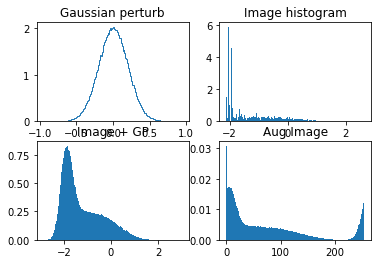

In [147]:
img = Image.open('/data1/sdi/datasets/CPN_all/Images/FH_I0000916_2.bmp').convert('RGB')
ma = Image.open('/data1/sdi/datasets/CPN_all/Masks/FH_I0000916_2_mask.bmp')

ext_trans = [ et.ExtToTensor(), 
                et.ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                et.GaussianPerturb(mean=0, std=0.1) ]

def genImage(im):
    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return (denorm(im.numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

pic1, _ = ext_trans[0](img, img)
pic, _ = ext_trans[1](pic1, _)
gp = np.random.normal(0, 0.2, np.shape(pic.numpy()))
tmp = pic + torch.from_numpy(gp)
pic2 = genImage(tmp)

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(gp.flatten(), bins=255, density=True, align='mid', histtype='step')
axs[0, 0].set_title('Gaussian perturb')
axs[0, 1].hist(np.array(pic, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
axs[0, 1].set_title('Image histogram')
axs[1, 0].hist(np.array(tmp, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
axs[1, 0].set_title('Image + GP')
axs[1, 1].hist(genImage(tmp).flatten(), bins=[i for i in range(255)], density=True, align='mid')
axs[1, 1].set_title('Aug Image')
plt.show()

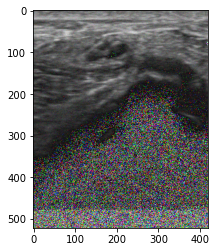

In [3]:
plt.imshow(pic2, )

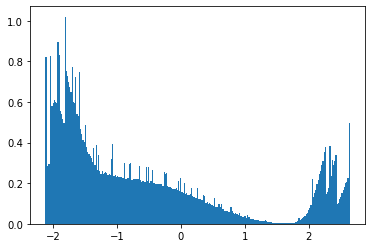

In [4]:
pic2 = genImage(tmp)
pic2, _ = ext_trans[0](pic2, img)
pic2, _ = ext_trans[1](pic2, _)
plt.hist(np.array(pic2, dtype=np.float32).flatten(), bins=255, density=True, align='mid')
plt.show()

In [234]:
print(image.dtype)
print(np.array(image).shape)
print(mask.dtype)
print(np.array(mask).shape)
print(np.array(image).transpose((1, 2, 0)).shape)
print(np.arange(0, 255, 0.1))

torch.float32
(1, 487, 414)
torch.int64
(487, 414)
(487, 414, 1)
[0.000e+00 1.000e-01 2.000e-01 ... 2.547e+02 2.548e+02 2.549e+02]


(10848,)


  1%|          | 1/100 [00:04<06:42,  4.07s/it]


pi: 1.0000, mu: 62.1593, sigma: 320.7777
mu:  62.15929203539823
sigma:  17.91026865774468


  1%|          | 1/100 [00:00<01:20,  1.23it/s]

1. Lower bound: 3539.4280030993064


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

2. Lower bound: 3539.4280030993064
pi: 1.0000, mu: -1.0529, sigma: 0.1041
mu:  -0.9076881
sigma:  0.35428563


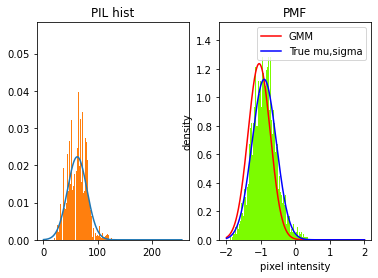

In [298]:
images = os.listdir('/data1/sdi/datasets/CPN_all/Images/')
cnt = 0

ext_trans = [ et.ExtToTensor(), 
                et.ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                et.GaussianPerturb(mean=0, std=0.1) ]

x = np.arange(0, 255, 0.1)
y = np.arange(-2, 2, 0.0001)

def gaussian(x, mean, sigma, pi = 1):
    return pi * (1 / np.sqrt(2*np.pi * sigma)) * np.exp(- (x-mean)**2 / (2*sigma))

for fname in images:
    cnt += 1
    mname = fname.split('.')[0] + "_mask." + fname.split('.')[-1]
    mask = os.path.join('/data1/sdi/datasets/CPN_all/Masks', mname)
    image = os.path.join('/data1/sdi/datasets/CPN_all/Images', fname)

    if not os.path.exists(mask) or not os.path.exists(image):
        raise Exception ("File Not Exists", mask, image)
    
    image = Image.open(image).convert("RGB")
    mask = Image.open(mask).convert("L")
    
    mm = GMM(C=1)
    print(np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten().shape)
    mm.fit(np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten().reshape((-1, 1)))

    pi = mm.parameters['pi'][0]
    mu = mm.parameters['mu'][0, 0]
    sigma = mm.parameters['sigma'][0, 0, 0]
    print("pi: %.4f, mu: %.4f, sigma: %.4f" % (pi, mu, sigma))
    print("mu: ", np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten().mean())
    print("sigma: ", np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten().std())
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(x, gaussian(x, mu, sigma, pi))
    axs[0].hist(np.array(image, dtype=np.uint8)[np.where(np.array(mask) > 0)].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
    axs[0].set_title('PIL hist')

    image, mask = ext_trans[0](image, mask)
    image, mask = ext_trans[1](image, mask)
    image, mask = ext_trans[2](image, mask)

    mm.fit((np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)], verbose=True, tol=0)
    
    pi = mm.parameters['pi'][0]
    mu = mm.parameters['mu'][0, 0]
    sigma = mm.parameters['sigma'][0, 0, 0]

    print("pi: %.4f, mu: %.4f, sigma: %.4f" % (pi, mu, sigma))
    print("mu: ", (np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)].mean())
    print("sigma: ", (np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)].std())
    #axs[0].plot(x, gaussian(x, mu, sigma, pi))
    legend = []
    axs[1].plot(y, gaussian(y, mu, sigma, pi), color='red')
    legend.append('GMM')
    axs[1].plot(y, gaussian(y, (np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)].mean(), (np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)].std()**2), pi, color='blue')
    legend.append('True mu,sigma')
    axs[1].hist((np.array(image, dtype=np.float32)).transpose((1, 2, 0))[np.where(np.array(mask) > 0)].flatten(), bins=500, density=True, align='mid', histtype='bar', color='lawngreen')
    axs[1].set_title('PMF')
    axs[1].legend(legend)
    plt.xlabel('pixel intensity')
    plt.ylabel('density')
    plt.savefig('/data1/sdi/PMF.png')
    plt.show()

    if cnt > 0:
        break

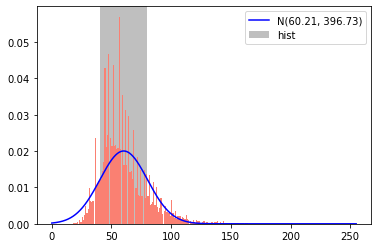

In [393]:
simg = Image.open('/data1/sdi/datasets/CPN_all/Images/FH_I0000677.bmp').convert('L')
sma = Image.open('/data1/sdi/datasets/CPN_all/Masks/FH_I0000677_mask.bmp')

def gaussian(x, mean, var, pi = 1):
    return pi * (1 / np.sqrt(2*np.pi * var)) * np.exp(- (x-mean)**2 / (2*var))

x = np.arange(0, 255, 0.1)

simg = np.array(simg, dtype=np.uint8)[np.where(np.array(sma) > 0)]

mean = simg.mean()
sigma = simg.std()
var = simg.std()**2

legend = []
plt.axvspan(mean - sigma, mean + sigma, facecolor='gray', alpha=0.5)
plt.plot(x, gaussian(x, mean, var), color='blue')
legend.append(f'N({mean:.2f}, {var:.2f})')
plt.hist(simg, bins=[i for i in range(255)], density=True, color='salmon')
legend.append('hist')
plt.legend(legend)
plt.show()

mean: 60.21 / std: 19.92
mean: 20.38 / std: 19.92
mean: -19.46 / std: 19.92
mean: 60.21 / std: 19.92
mean: 100.05 / std: 19.92
mean: 139.88 / std: 19.92
mean: 179.72 / std: 19.92
mean: 219.56 / std: 19.92
mean: 259.39 / std: 19.92


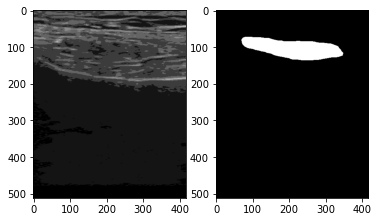

In [417]:
simg = Image.open('/data1/sdi/datasets/CPN_all/Images/FH_I0000677.bmp').convert('RGB')
ma = Image.open('/data1/sdi/datasets/CPN_all/Masks/FH_I0000677_mask.bmp')
example = np.array(simg)

def get_interval(image, result, mean, sigma):
    print(f'mean: {mean:.2f} / std: {sigma:.2f}')
    if mean - sigma > 0:
        result[(image > mean-sigma) * (image < mean+sigma)] = int(mean)
        get_interval(image, result, mean - 2*sigma, sigma)
    else:
        result[(image > mean-sigma) * (image < mean+sigma)] = 0
    return result

def get_up_interval(image, result, mean, sigma):
    print(f'mean: {mean:.2f} / std: {sigma:.2f}')
    if mean + sigma <= 255:
        result[(image > mean-sigma) * (image < mean+sigma)] = int(mean)
        get_up_interval(image, result, mean + 2*sigma, sigma)
    else:
        result[(image > mean-sigma) * (image < mean+sigma)] = 255
    return result

result = get_interval(example, np.zeros_like(example), mean, sigma)
result = Image.fromarray(get_up_interval(example, result, mean, sigma))

result.save('/data1/sdi/datasets/CPN_all_gmm/1sigma/test1.png', 'PNG')
plt.figure()
plt.subplot(121), plt.imshow(result, cmap='gray')
plt.subplot(122), plt.imshow(ma, cmap='gray')
plt.show()


In [ ]:
images = os.listdir('/data1/sdi/datasets/CPN_all/Images/')

for fname in images:
    if not os.path.exists(os.path.join('/data1/sdi/datasets/CPN_all/Images/', fname)):
        raise Exception
    image = Image.open(os.path.join('/data1/sdi/datasets/CPN_all/Images/', fname)).convert('RGB')
    

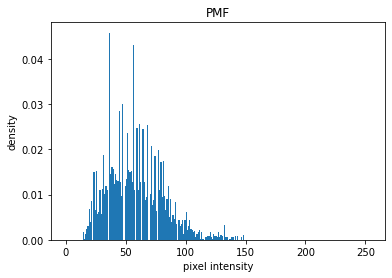

In [130]:
plt.hist(np.array(img, dtype=np.uint8)[np.where(np.array(ma) > 0)].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
plt.title('PMF')
plt.xlabel('pixel intensity')
plt.ylabel('density')
#plt.savefig('/data1/sdi/PMF.png')
plt.show()

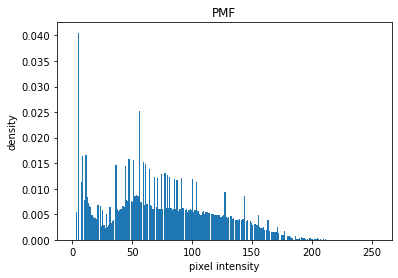

In [131]:
plt.hist(np.array(img, dtype=np.uint8)[0:300,0:300,:].flatten(), bins=[i for i in range(255)], density=True, align='mid', histtype='bar')
plt.title('PMF')
plt.xlabel('pixel intensity')
plt.ylabel('density')
#plt.savefig('/data1/sdi/PMF.png')
plt.show()

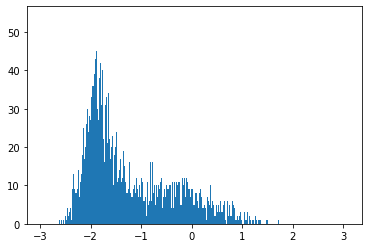

In [106]:
import numpy as np
from gmm import GMM

CLUSTER = 5
#data = np.random.normal(-5, 1, (500, 1))
#data_alpha = np.random.normal(5, 1, (500, 1))
#data = np.append(data, data_alpha).reshape((1000, 1))
data = np.array(tmp, dtype=np.float32).reshape((-1, 1))

plt.hist(data, bins=100000)
plt.show()

In [100]:
mm = GMM(C=CLUSTER)
mm.fit(data)

100%|██████████| 100/100 [7:44:58<00:00, 278.99s/it] 


0

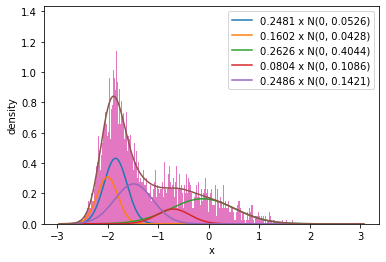

In [264]:
import matplotlib.pyplot as plt

x = np.arange(round(data.min(), 3), round(data.max(), 3), 0.005)

def gaussian(x, mean, sigma, pi):
    return pi * (1 / np.sqrt(2*np.pi * sigma)) * np.exp(- (x-mean)**2 / (2*sigma))

mm.parameters['mu'] = np.array([[-1.84954882],
       [-2.00885996],
       [-0.12378937],
       [-0.70531978],
       [-1.49054159]])

mm.parameters['sigma'] = np.array([[[0.05260948]],

       [[0.04282496]],

       [[0.40440687]],

       [[0.10857593]],

       [[0.14214313]]])

mm.parameters['pi'] = np.array([0.2481, 0.1602, 0.2626, 0.0804, 0.2486])

legend = []
for i in range(0, CLUSTER):
    pi = mm.parameters['pi'][i]
    mu = mm.parameters['mu'][i, 0]
    sigma = mm.parameters['sigma'][i, 0, 0]
    legend.append(f'{pi:.4f} x N(0, {sigma:.4f})')
    plt.plot(x, gaussian(x, mu, sigma, pi))
    if i == 0:
        total = gaussian(x, mu, sigma, pi)
    else:
        total += gaussian(x, mu, sigma, pi)

plt.plot(x, total)
plt.hist(data, bins=100000, density=True)

plt.xlabel('x')
plt.ylabel('density')
plt.legend(legend)
plt.show()

In [102]:
mm.parameters['mu']

array([[-1.84954882],
       [-2.00885996],
       [-0.12378937],
       [-0.70531978],
       [-1.49054159]])

In [103]:
mm.parameters['sigma']

array([[[0.05260948]],

       [[0.04282496]],

       [[0.40440687]],

       [[0.10857593]],

       [[0.14214313]]])

In [94]:
np.array(tmp, dtype=np.float32).reshape((-1, 1)).shape

(656154, 1)